# Import modules

In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from xgboost import XGBClassifier, plot_importance

from matplotlib import pyplot

# Dataset cleaning

defined funtions for dataset cleaning. load_csv_data() loads UNSW-NB15 csv files, and returns a cleaned pandas dataframe. sklearn libraries assume normal cases as 1 and abnormal cases -1, but UNSW-NB15 uses 1 as abnormal cases, and 0 as normal cases. y_anomaly_format converts UNSW-NB15 label formats into sklearn's formats.

In [3]:
def load_csv_data(path, strategy='all_columns', to_exclude='object', anomaly_format=True):
    """
    Function for loading data from UNSW-NB15 csv data.
    Assumes the csv has a header row and an index column when
    creating the dataframe to return.
    """

    data = pd.read_csv(path,header=0, index_col=0)
    
    if strategy == 'all_columns': # exclude attack_category, label
        if anomaly_format == True:
            return data.iloc[:, :-2], data.label.apply(y_anomaly_format)
        else:
            return data.iloc[:, :-2], data.label

    elif strategy == 'only_numeric':
        numeric_features = data.select_dtypes(exclude='object').iloc[:,:-1] # include only numeric data
        if anomaly_format == True:
            return numeric_features, data.label.apply(y_anomaly_format) # 1 for normal cases, -1 for abnormal cases
        else:
            return numeric_features, data.label
    
    elif strategy == 'label_encoder':
        # encode non_numeric values(proto, service, state) into numeric values
        proto_encoder = LabelEncoder()
        service_encoder = LabelEncoder()
        state_encoder = LabelEncoder()
        
        proto_encoder.fit(data['proto'])
        service_encoder.fit(data['service'])
        state_encoder.fit(data['state'])
        
        data['proto'] = proto_encoder.transform(data['proto'])
        data['service'] = service_encoder.transform(data['service'])
        data['state'] = state_encoder.transform(data['state'])
        
        if anomaly_format == True:
            return data.iloc[:, :-2], data.label.apply(y_anomaly_format)
        else:
            return data.iloc[:, :-2], data.label
    
    
def y_anomaly_format(y):
    '''
    Accepts a target value of 0 or 1 and reformats to the appropriate class for sklearn's anomaly models.
    inlier(normal case): 0 -> 1
    outlier(abnormal case): 1 -> -1
    '''
    if y == 0:
        return 1
    elif y == 1:
        return -1
    else:
        print('Unexpected input:', y)
        raise ValueError ('Unexpected input')
        
        
X_funtest, y_funtest = load_csv_data('./UNSW_NB15_training-set.csv', strategy='only_numeric')
print('X_funtest')
X_funtest

X_funtest


,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
id,,,,,,,,,,,,,,,,,,,,,
1,0.121478,6,4,258,172,74.087490,252,254,1.415894e+04,8495.365234,...,1,1,1,1,0,0,0,1,1,0
2,0.649902,14,38,734,42014,78.473372,62,252,8.395112e+03,503571.312500,...,1,1,1,2,0,0,0,1,6,0
3,1.623129,8,16,364,13186,14.170161,62,252,1.572272e+03,60929.230470,...,2,1,1,3,0,0,0,2,6,0
4,1.681642,12,12,628,770,13.677108,62,252,2.740179e+03,3358.622070,...,2,1,1,3,1,1,0,2,1,0
5,0.449454,10,6,534,268,33.373826,254,252,8.561499e+03,3987.059814,...,2,2,1,40,0,0,0,2,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175337,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,24,24,13,24,0,0,0,24,24,0
175338,0.505762,10,8,620,354,33.612649,254,252,8.826286e+03,4903.492188,...,1,1,1,2,0,0,0,1,1,0
175339,0.000009,2,0,114,0,111111.107200,254,0,5.066666e+07,0.000000,...,3,3,3,13,0,0,0,3,12,0


In [4]:
print('y_funtest')
y_funtest

y_funtest


id
1         1
2         1
3         1
4         1
5         1
         ..
175337   -1
175338   -1
175339   -1
175340   -1
175341   -1
Name: label, Length: 175341, dtype: int64

# Scaling

defined functions for scaling data.

In [5]:
def scale(data, strategy='none'):
    """
    Wrapper function for scaling column data. returns the scaled dataframe and fitted scaler.
    assumes that input data have only numeric columns.
    """
    
    if strategy == 'none': # no scaling(returns original input data)
        return data
    
    elif strategy == 'min_max': # applys min-max scaling
        scaler = MinMaxScaler()
        numeric_features = data.iloc[:,:]
        
        scaler.fit(numeric_features)
        scaled_data = scaler.transform(numeric_features)
        
        scaled_df = pd.DataFrame(scaled_data, columns=numeric_features.columns.tolist(), index=data.index)
        return scaled_df, scaler
    
    elif strategy == 'std_scaler': # applys standard scaling
        scaler = StandardScaler()
        numeric_features = data.iloc[:,:]
        
        scaler.fit(numeric_features)
        scaled_data = scaler.transform(numeric_features)
        
        scaled_df = pd.DataFrame(scaled_data, columns=numeric_features.columns.tolist(), index=data.index)
        return scaled_df, scaler
    
    
def scaleTestData(test_data, scaler):
    '''
    scales test data using the trainning data's scaler.
    returns scaled test dataframe.
    '''
    numeric_features = test_data.iloc[:,:]
    scaled_data = scaler.transform(numeric_features)
    scaled_df = pd.DataFrame(scaled_data, columns=numeric_features.columns.tolist(), index=test_data.index)
    return scaled_df

In [6]:
X_funtest_scaled, std_scaler = scale(X_funtest, strategy = 'std_scaler')
X_funtest_scaled

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
id,,,,,,,,,,,,,,,,,,,,,
1,-0.191029,-0.104456,-0.135769,-0.049134,-0.102726,-0.576371,0.703839,1.578100,-0.389897,-0.273700,...,-0.645013,-0.544736,-0.554373,-0.705529,-0.118590,-0.118590,-0.189768,-0.715714,-0.753074,-0.126508
2,-0.109485,-0.046014,0.172599,-0.046410,0.188544,-0.576345,-1.141901,1.560002,-0.389928,-0.069233,...,-0.645013,-0.544736,-0.554373,-0.614256,-0.118590,-0.118590,-0.189768,-0.715714,-0.288257,-0.126508
3,0.040699,-0.089845,-0.026933,-0.048527,-0.012133,-0.576734,-1.141901,1.560002,-0.389964,-0.252044,...,-0.520827,-0.544736,-0.554373,-0.522983,-0.118590,-0.118590,-0.189768,-0.595543,-0.288257,-0.126508
4,0.049729,-0.060624,-0.063212,-0.047016,-0.098563,-0.576737,-1.141901,1.560002,-0.389958,-0.275821,...,-0.520827,-0.544736,-0.554373,-0.522983,7.814915,7.814915,-0.189768,-0.595543,-0.753074,-0.126508
5,-0.140417,-0.075235,-0.117630,-0.047554,-0.102057,-0.576617,0.723268,1.560002,-0.389927,-0.275561,...,-0.520827,-0.420468,-0.554373,2.854115,-0.118590,-0.118590,-0.189768,-0.595543,2.779535,-0.126508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175337,-0.209773,-0.133677,-0.172047,-0.049958,-0.103923,0.094951,0.723268,-0.720406,-0.120980,-0.277208,...,2.211259,2.313443,1.520470,1.393748,-0.118590,-0.118590,-0.189768,2.048221,1.385084,-0.126508
175338,-0.131728,-0.075235,-0.099490,-0.047062,-0.101459,-0.576616,0.723268,1.560002,-0.389926,-0.275183,...,-0.645013,-0.544736,-0.554373,-0.614256,-0.118590,-0.118590,-0.189768,-0.715714,-0.753074,-0.126508
175339,-0.209773,-0.133677,-0.172047,-0.049958,-0.103923,0.094951,0.723268,-0.720406,-0.120980,-0.277208,...,-0.396641,-0.296199,-0.208566,0.389746,-0.118590,-0.118590,-0.189768,-0.475371,0.269523,-0.126508


In [7]:
std_scaler

StandardScaler()

# Feature selection

Normaly, it is known that a feature selection generally lowers the model's performance.
so no feature selection has been applied in the model training section.

## XGBoost

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 864x1152 with 0 Axes>

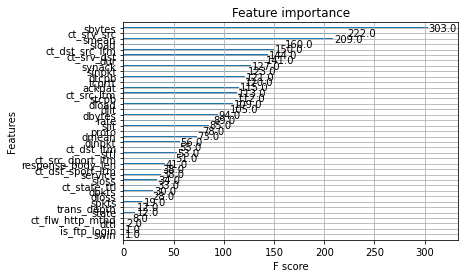

In [8]:
X_train, y_train = load_csv_data('./UNSW_NB15_training-set.csv', strategy='label_encoder', anomaly_format=False)
X_train

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

pyplot.figure(figsize=(12,16))
plot_importance(xgb)

In [9]:
def selectFeature(data, strategy='all_features'):
    """
    Wrapper function for feature selection.
    """
    
    if strategy == 'all_features':
        return data
    
    elif strategy == 'XGBoost':
        return data
        
    elif strategy == 'MIMCA':
        return data
        

# Dataset Preprocessing

|Dataset|Cleaning|Scaling|Feature Selection|Train-Test set split method|
|---|---|---|---|---|
|X1|Only Numeric Columns|-|-|Use Original Train-Test set|
|X2|Only Numeric Columns|Min-Max Scaling|-|Use Original Train-Test set|
|X3|LabelEncoder|-|-|Use Original Train-Test set|
|X4|LabelEncoder|Min-Max Scaling|-|Use Original Train-Test set|
|X5|LabelEncoder|Standard Scaling|-|Use Original Train-Test set|
|X6|LabelEncoder|-|-|Concatenate Original Test/Train set, and split(75:25)|

In [10]:
X1_train, y1_train = load_csv_data('./UNSW_NB15_training-set.csv', strategy='only_numeric')
X1_train = scale(X1_train, strategy = 'none')
X1_train = selectFeature(X1_train, strategy = 'all_features')

X1_test, y1_test = load_csv_data('./UNSW_NB15_testing-set.csv', strategy='only_numeric')


# Create 'masks' to filter the dataframe by whether or not the observation belongs to normal or attack class.
# for example, X1_train[train_normal] will contain only normal trainning data.
train_normal = y1_train==1
test_normal = y1_test==1

X1_train[train_normal]

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
id,,,,,,,,,,,,,,,,,,,,,
1,0.121478,6,4,258,172,74.087490,252,254,14158.942380,8495.365234,...,1,1,1,1,0,0,0,1,1,0
2,0.649902,14,38,734,42014,78.473372,62,252,8395.112305,503571.312500,...,1,1,1,2,0,0,0,1,6,0
3,1.623129,8,16,364,13186,14.170161,62,252,1572.271851,60929.230470,...,2,1,1,3,0,0,0,2,6,0
4,1.681642,12,12,628,770,13.677108,62,252,2740.178955,3358.622070,...,2,1,1,3,1,1,0,2,1,0
5,0.449454,10,6,534,268,33.373826,254,252,8561.499023,3987.059814,...,2,2,1,40,0,0,0,2,39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115957,0.000000,1,0,46,0,0.000000,0,0,0.000000,0.000000,...,2,2,2,2,0,0,0,2,2,1
115958,59.995781,2,0,92,0,0.016668,0,0,6.133765,0.000000,...,2,2,2,2,0,0,0,2,2,1
115961,59.995781,2,0,92,0,0.016668,0,0,6.133765,0.000000,...,2,2,2,2,0,0,0,2,2,1


In [11]:
X2_train, y2_train = load_csv_data('./UNSW_NB15_training-set.csv', strategy='only_numeric')
X2_train, X2_scaler = scale(X2_train, strategy = 'min_max')
X2_train = selectFeature(X2_train, strategy = 'all_features')

X2_test, y2_test = load_csv_data('./UNSW_NB15_testing-set.csv', strategy='only_numeric')
X2_test = scaleTestData(X2_test, X2_scaler)
X2_test = selectFeature(X2_test, strategy = 'all_features')

# Create 'masks' to filter the dataframe by whether or not the observation belongs to normal or attack class.
train_normal2 = y2_train==1

X2_train

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
id,,,,,,,,,,,,,,,,,,,,,
1,2.024634e-03,0.000520,0.000364,0.000018,0.000012,0.000074,0.988235,1.000000,2.364553e-06,0.000379,...,0.00,0.00,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
2,1.083170e-02,0.001352,0.003463,0.000054,0.002867,0.000078,0.243137,0.992126,1.401989e-06,0.022458,...,0.00,0.00,0.000000,0.015625,0.00,0.00,0.0,0.000000,0.081967,0.0
3,2.705215e-02,0.000728,0.001458,0.000026,0.000900,0.000014,0.243137,0.992126,2.625704e-07,0.002717,...,0.02,0.00,0.000000,0.031250,0.00,0.00,0.0,0.016949,0.081967,0.0
4,2.802737e-02,0.001144,0.001093,0.000046,0.000053,0.000014,0.243137,0.992126,4.576117e-07,0.000150,...,0.02,0.00,0.000000,0.031250,0.25,0.25,0.0,0.016949,0.000000,0.0
5,7.490901e-03,0.000936,0.000547,0.000039,0.000018,0.000033,0.996078,0.992126,1.429776e-06,0.000178,...,0.02,0.02,0.000000,0.609375,0.00,0.00,0.0,0.016949,0.622951,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175337,1.500000e-07,0.000104,0.000000,0.000007,0.000000,0.111111,0.996078,0.000000,8.461366e-03,0.000000,...,0.46,0.46,0.266667,0.359375,0.00,0.00,0.0,0.389831,0.377049,0.0
175338,8.429368e-03,0.000936,0.000729,0.000046,0.000024,0.000034,0.996078,0.992126,1.473996e-06,0.000219,...,0.00,0.00,0.000000,0.015625,0.00,0.00,0.0,0.000000,0.000000,0.0
175339,1.500000e-07,0.000104,0.000000,0.000007,0.000000,0.111111,0.996078,0.000000,8.461366e-03,0.000000,...,0.04,0.04,0.044444,0.187500,0.00,0.00,0.0,0.033898,0.180328,0.0


In [12]:
X3_train, y3_train = load_csv_data('./UNSW_NB15_training-set.csv', strategy='label_encoder')
X3_train = scale(X3_train, strategy = 'none')
X3_train = selectFeature(X3_train, strategy = 'all_features')

X3_test, y3_test = load_csv_data('./UNSW_NB15_testing-set.csv', strategy='label_encoder')

# Create 'masks' to filter the dataframe by whether or not the observation belongs to normal or attack class.
train_normal3 = y3_train==1

X3_train[~train_normal3]

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
id,,,,,,,,,,,,,,,,,,,,,
47912,0.000009,20,0,3,2,0,200,0,111111.107200,254,...,1,1,1,4,0,0,0,2,4,0
47913,0.000009,53,0,3,2,0,200,0,111111.107200,254,...,2,2,2,7,0,0,0,2,7,0
47914,0.000009,12,0,3,2,0,200,0,111111.107200,254,...,1,1,1,6,0,0,0,1,6,0
47915,0.000003,128,0,3,2,0,200,0,333333.321500,254,...,2,2,2,7,0,0,0,2,6,0
47916,0.000008,87,0,3,2,0,200,0,125000.000300,254,...,1,1,1,4,0,0,0,11,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175337,0.000009,119,2,3,2,0,114,0,111111.107200,254,...,24,24,13,24,0,0,0,24,24,0
175338,0.505762,113,0,2,10,8,620,354,33.612649,254,...,1,1,1,2,0,0,0,1,1,0
175339,0.000009,119,2,3,2,0,114,0,111111.107200,254,...,3,3,3,13,0,0,0,3,12,0


In [13]:
X4_train, y4_train = load_csv_data('./UNSW_NB15_training-set.csv', strategy='label_encoder')
X4_train, X4_scaler = scale(X4_train, strategy = 'min_max')
X4_train = selectFeature(X4_train, strategy = 'all_features')

X4_test, y4_test = load_csv_data('./UNSW_NB15_testing-set.csv', strategy='label_encoder')
X4_test = scaleTestData(X4_test, X4_scaler)
X4_test = selectFeature(X4_test, strategy = 'all_features')

# Create 'masks' to filter the dataframe by whether or not the observation belongs to normal or attack class.
train_normal4 = y4_train==1

X4_train[train_normal4]

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
id,,,,,,,,,,,,,,,,,,,,,
1,0.002025,0.856061,0.00,0.250,0.000520,0.000364,0.000018,0.000012,7.408749e-05,0.988235,...,0.00,0.00,0.000000,0.000000,0.00,0.00,0.0,0.000000,0.000000,0.0
2,0.010832,0.856061,0.00,0.250,0.001352,0.003463,0.000054,0.002867,7.847337e-05,0.243137,...,0.00,0.00,0.000000,0.015625,0.00,0.00,0.0,0.000000,0.081967,0.0
3,0.027052,0.856061,0.00,0.250,0.000728,0.001458,0.000026,0.000900,1.417016e-05,0.243137,...,0.02,0.00,0.000000,0.031250,0.00,0.00,0.0,0.016949,0.081967,0.0
4,0.028027,0.856061,0.25,0.250,0.001144,0.001093,0.000046,0.000053,1.367711e-05,0.243137,...,0.02,0.00,0.000000,0.031250,0.25,0.25,0.0,0.016949,0.000000,0.0
5,0.007491,0.856061,0.00,0.250,0.000936,0.000547,0.000039,0.000018,3.337383e-05,0.996078,...,0.02,0.02,0.000000,0.609375,0.00,0.00,0.0,0.016949,0.622951,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115957,0.000000,0.045455,0.00,0.375,0.000000,0.000000,0.000001,0.000000,0.000000e+00,0.000000,...,0.02,0.02,0.022222,0.015625,0.00,0.00,0.0,0.016949,0.016393,1.0
115958,0.999930,0.045455,0.00,0.375,0.000104,0.000000,0.000005,0.000000,1.666800e-08,0.000000,...,0.02,0.02,0.022222,0.015625,0.00,0.00,0.0,0.016949,0.016393,1.0
115961,0.999930,0.045455,0.00,0.375,0.000104,0.000000,0.000005,0.000000,1.666800e-08,0.000000,...,0.02,0.02,0.022222,0.015625,0.00,0.00,0.0,0.016949,0.016393,1.0


In [14]:
X5_train, y5_train = load_csv_data('./UNSW_NB15_training-set.csv', strategy='label_encoder')
X5_train, X5_scaler = scale(X5_train, strategy = 'std_scaler')
X5_train = selectFeature(X5_train, strategy = 'all_features')

X5_test, y5_test = load_csv_data('./UNSW_NB15_testing-set.csv', strategy='label_encoder')
X5_test = scaleTestData(X5_test, X5_scaler)
X5_test = selectFeature(X5_test, strategy = 'all_features')

# Create 'masks' to filter the dataframe by whether or not the observation belongs to normal or attack class.
train_normal5 = y5_train==1

X5_train

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
id,,,,,,,,,,,,,,,,,,,,,
1,-0.191029,0.151809,-0.702307,-0.409218,-0.104456,-0.135769,-0.049134,-0.102726,-0.576371,0.703839,...,-0.645013,-0.544736,-0.554373,-0.705529,-0.118590,-0.118590,-0.189768,-0.715714,-0.753074,-0.126508
2,-0.109485,0.151809,-0.702307,-0.409218,-0.046014,0.172599,-0.046410,0.188544,-0.576345,-1.141901,...,-0.645013,-0.544736,-0.554373,-0.614256,-0.118590,-0.118590,-0.189768,-0.715714,-0.288257,-0.126508
3,0.040699,0.151809,-0.702307,-0.409218,-0.089845,-0.026933,-0.048527,-0.012133,-0.576734,-1.141901,...,-0.520827,-0.544736,-0.554373,-0.522983,-0.118590,-0.118590,-0.189768,-0.595543,-0.288257,-0.126508
4,0.049729,0.151809,0.599130,-0.409218,-0.060624,-0.063212,-0.047016,-0.098563,-0.576737,-1.141901,...,-0.520827,-0.544736,-0.554373,-0.522983,7.814915,7.814915,-0.189768,-0.595543,-0.753074,-0.126508
5,-0.140417,0.151809,-0.702307,-0.409218,-0.075235,-0.117630,-0.047554,-0.102057,-0.576617,0.723268,...,-0.520827,-0.420468,-0.554373,2.854115,-0.118590,-0.118590,-0.189768,-0.595543,2.779535,-0.126508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175337,-0.209773,0.420235,0.165317,0.742936,-0.133677,-0.172047,-0.049958,-0.103923,0.094951,0.723268,...,2.211259,2.313443,1.520470,1.393748,-0.118590,-0.118590,-0.189768,2.048221,1.385084,-0.126508
175338,-0.131728,0.151809,-0.702307,-0.409218,-0.075235,-0.099490,-0.047062,-0.101459,-0.576616,0.723268,...,-0.645013,-0.544736,-0.554373,-0.614256,-0.118590,-0.118590,-0.189768,-0.715714,-0.753074,-0.126508
175339,-0.209773,0.420235,0.165317,0.742936,-0.133677,-0.172047,-0.049958,-0.103923,0.094951,0.723268,...,-0.396641,-0.296199,-0.208566,0.389746,-0.118590,-0.118590,-0.189768,-0.475371,0.269523,-0.126508


In [39]:
X6_train, y6_train = load_csv_data('./UNSW_NB15_training-set.csv', strategy='label_encoder')
X6_test, y6_test = load_csv_data('./UNSW_NB15_testing-set.csv', strategy='label_encoder')

X6_concat = pd.concat([X6_train, X6_test], ignore_index=True)
y6_concat = pd.concat([y6_train, y6_test], ignore_index=True)

X6_train, X6_test, y6_train, y6_test = train_test_split(X6_concat, y6_concat, test_size = 0.25, random_state = 42, stratify=y6_concat)
# skip scaling

# Create 'masks' to filter the dataframe by whether or not the observation belongs to normal or attack class.
train_normal6 = y6_train==1

X6_train[train_normal6]

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports
208113,0.050994,111,0,3,46,48,2854,30622,1.823744e+03,31,...,7,1,1,3,0,0,0,8,9,0
213025,0.047358,111,0,3,122,126,7814,14840,5.215592e+03,31,...,1,1,1,1,0,0,0,5,4,0
14817,8.046450,113,0,2,454,858,25472,1094788,1.629290e+02,31,...,2,1,1,3,0,0,0,1,10,0
242095,0.000001,117,0,4,2,0,104,0,1.000000e+06,254,...,1,1,1,1,0,0,0,4,1,0
12737,0.006368,113,11,2,32,24,3728,5474,8.636935e+03,31,...,2,1,1,1,0,0,0,3,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247417,0.494659,111,0,3,10,6,1612,268,3.032392e+01,254,...,2,2,1,6,0,0,0,2,6,0
40210,0.001062,119,2,0,2,2,146,178,2.824859e+03,31,...,3,1,1,1,0,0,0,2,2,0
12205,0.223443,113,4,2,14,6,8928,320,8.503287e+01,31,...,2,1,1,2,0,0,0,3,5,0
39070,0.164848,113,0,2,66,68,3926,57474,8.068038e+02,31,...,4,1,1,1,0,0,0,4,5,0


# Model Training

In [17]:
def trainAndPrintResult(model, X_train, X_test, y_test):
    '''
    trains input model with data X, and prints the result.
    X must be normal data. y is test data label.
    '''
    model.fit(X_train) # train model with only normal data.
    y_test_pred = model.predict(X_test)
    
    print(confusion_matrix(y_test, y_test_pred))
    print('precision = ', precision_score(y_test, y_test_pred))
    print('recall = ', recall_score(y_test, y_test_pred))
    print('f1_score = ', f1_score(y_test, y_test_pred))

## One-class SVM

descriptions about the module can be found on below:
#### https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM

In [18]:
from sklearn.svm import OneClassSVM

ocsvm = OneClassSVM(kernel='rbf')
trainAndPrintResult(ocsvm, X1_train[train_normal], X1_test, y1_test)

[[13245 32087]
 [17846 19154]]
precision =  0.3738022286840616
recall =  0.5176756756756756
f1_score =  0.4341292596412099


In [19]:
ocsvm2 = OneClassSVM(kernel='rbf')
trainAndPrintResult(ocsvm2, X2_train[train_normal2], X2_test, y2_test)

[[42060  3272]
 [23608 13392]]
precision =  0.8036485837734038
recall =  0.3619459459459459
f1_score =  0.4991055456171735


In [20]:
ocsvm3 = OneClassSVM(kernel='rbf')
trainAndPrintResult(ocsvm3, X3_train[train_normal3], X3_test, y3_test)

[[13248 32084]
 [17875 19125]]
precision =  0.3734695073131676
recall =  0.5168918918918919
f1_score =  0.4336292215080094


In [21]:
ocsvm4 = OneClassSVM(kernel='rbf')
trainAndPrintResult(ocsvm4, X4_train[train_normal4], X4_test, y4_test)

[[42544  2788]
 [21062 15938]]
precision =  0.8511160952686105
recall =  0.43075675675675673
f1_score =  0.5720130639198938


In [22]:
ocsvm5 = OneClassSVM(kernel='rbf')
trainAndPrintResult(ocsvm5, X5_train[train_normal5], X5_test, y5_test)

[[41284  4048]
 [23989 13011]]
precision =  0.7627059030423823
recall =  0.35164864864864864
f1_score =  0.48136295528959094


In [40]:
ocsvm6 = OneClassSVM(kernel='rbf')
trainAndPrintResult(ocsvm6, X6_train[train_normal6], X6_test, y6_test)

[[12252 28917]
 [11636 11614]]
precision =  0.2865461005156547
recall =  0.4995268817204301
f1_score =  0.3641836910678729


## Isolation Forest

descriptions about the module can be found on below:
#### https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest

In [23]:
from sklearn.ensemble import IsolationForest

ilf1 = IsolationForest(random_state=42)
trainAndPrintResult(ilf1, X1_train[train_normal], X1_test, y1_test)

[[12522 32810]
 [ 2586 34414]]
precision =  0.5119302630013091
recall =  0.9301081081081081
f1_score =  0.6603853239177156


"\nilf1 = IsolationForest(random_state=42)\nilf1.fit(X1_train[train_normal])\n\ny1_pred_test = ilf1.predict(X1_test)\n\nprint(confusion_matrix(y1_test, y1_pred_test))\nprint('precision = ', precision_score(y1_test, y1_pred_test))\nprint('recall = ', recall_score(y1_test, y1_pred_test))\nprint('f1_score = ', f1_score(y1_test, y1_pred_test))\n"

In [24]:
ilf2 = IsolationForest(random_state=42)
trainAndPrintResult(ilf2, X2_train[train_normal2], X2_test, y2_test)

[[12648 32684]
 [ 2661 34339]]
precision =  0.5123465079151933
recall =  0.9280810810810811
f1_score =  0.660219374561395


"\nilf2 = IsolationForest(random_state=42)\nilf2.fit(X2_train[train_normal2])\n\ny2_pred_test = ilf2.predict(X2_test)\n\nprint(confusion_matrix(y2_test, y2_pred_test))\nprint('precision = ', precision_score(y2_test, y2_pred_test))\nprint('recall = ', recall_score(y2_test, y2_pred_test))\nprint('f1_score = ', f1_score(y2_test, y2_pred_test))\n"

In [25]:
ilf3 = IsolationForest(random_state=42)
trainAndPrintResult(ilf3, X3_train[train_normal3], X3_test, y3_test)

[[13517 31815]
 [ 3140 33860]]
precision =  0.5155690902169775
recall =  0.9151351351351351
f1_score =  0.6595568541514487


In [26]:
ilf4 = IsolationForest(random_state=42)
trainAndPrintResult(ilf4, X4_train[train_normal4], X4_test, y4_test)

[[13127 32205]
 [ 3013 33987]]
precision =  0.5134608411892676
recall =  0.9185675675675675
f1_score =  0.6587138537871153


In [27]:
ilf5 = IsolationForest(random_state=42)
trainAndPrintResult(ilf5, X5_train[train_normal5], X5_test, y5_test)

[[13682 31650]
 [ 3222 33778]]
precision =  0.516262150761142
recall =  0.912918918918919
f1_score =  0.6595462178310618


In [41]:
ilf6 = IsolationForest(random_state=42)
trainAndPrintResult(ilf6, X6_train[train_normal6], X6_test, y6_test)

[[12116 29053]
 [ 1328 21922]]
precision =  0.4300539480137322
recall =  0.9428817204301075
f1_score =  0.5906904681711013


## Elliptic Envelope

descriptions about the module can be found on below:
#### https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html?highlight=envelope#sklearn.covariance.EllipticEnvelope

In [29]:
from sklearn.covariance import EllipticEnvelope

eenv1 = EllipticEnvelope(random_state=42)
trainAndPrintResult(eenv1, X1_train[train_normal], X1_test, y1_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (166.215029140445097 > 156.931972738132259). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (114.842210401385159 > 108.687039388786673). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sk

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (176.936097799651748 > 166.803078555455528). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (135.294362365080843 > 107.571853879555064). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (115.249221975036761 > 108.901738296210169). You may want to try with a 

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (154.782269060502415 > 134.279657596966842). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (129.778341465527859 > 114.017539527598927). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (126.061821884268625 > 99.043204262397126). You may want to try with a h

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (96.951627543728463 > 83.171847029695243). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (137.898262765713952 > 119.855246055592772). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (100.503677461283630 > 88.237535625842796). You may want to try with a hig

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (129.907545550617243 > 78.295601205358594). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (115.602533657849591 > 105.236194971872578). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (125.419869059220133 > 107.228412291889725). You may want to try with a h

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (102.131957768097408 > 84.932222703085614). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (121.654159995387047 > 103.130759978423654). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (137.792555944542585 > 88.331197312527138). You may want to try with a hi

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (96.330749791092842 > 71.517080411539368). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (127.238803545348617 > 101.115819591725341). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (83.751654245450538 > 59.404273955480186). You may want to try with a high

[[30253 15079]
 [ 5965 31035]]
precision =  0.6730060285379711
recall =  0.8387837837837838
f1_score =  0.7468055923189836


In [23]:
eenv2 = EllipticEnvelope(random_state=42)
trainAndPrintResult(eenv2, X2_train[train_normal2], X2_test, y2_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


[[ 2316 43016]
 [ 4382 32618]]
precision =  0.4312610730623794
recall =  0.8815675675675676
f1_score =  0.579185681055454


In [30]:
eenv3 = EllipticEnvelope(random_state=42)
trainAndPrintResult(eenv3, X3_train[train_normal3], X3_test, y3_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (95.479607598942863 > 93.188239371597902). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (84.883956625084096 > 75.111641601849357). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklear

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (86.018719293959549 > 57.571370101737386). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (63.884905695657466 > 63.035701089349814). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (131.568179303325053 > 60.056754579312852). You may want to try with a highe

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (103.407363323658714 > 50.602310086054004). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (132.269979412562293 > 118.405566283770384). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (135.894485833932123 > 96.427621886527106). You may want to try with a hi

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (131.249449651952347 > 124.928509402299795). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (127.743429324494571 > 43.219229586568801). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (101.628811994460733 > 80.467168700799135). You may want to try with a hi

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (133.534684258467649 > 83.843061390995970). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (95.975948920760644 > 80.470244778512694). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (119.935800256905679 > 101.257542463384084). You may want to try with a hig

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (98.783802944363629 > 82.885132846337711). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (129.782740466569209 > 77.484006670181770). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (102.843572825856768 > 76.347010099623134). You may want to try with a high

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (168.847750643547784 > 87.375932199177072). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (132.968220807229898 > 119.615383985377704). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (132.725529193602938 > 51.556505665307810). You may want to try with a hi

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (137.442068811119327 > 54.604796404697709). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (129.034475735927373 > 84.791373622787802). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (136.253129063804380 > 77.489617738343611). You may want to try with a hig

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (134.030384422974691 > 99.499427129102642). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (103.458385028732465 > 77.996602721752794). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (102.685239245620991 > 75.813500044974063). You may want to try with a hig

[[30198 15134]
 [ 5952 31048]]
precision =  0.6722965657615522
recall =  0.8391351351351352
f1_score =  0.7465076579067587


In [31]:
eenv4 = EllipticEnvelope(random_state=42)
trainAndPrintResult(eenv4, X4_train[train_normal4], X4_test, y4_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


[[11810 33522]
 [ 8129 28871]]
precision =  0.46272819066241405
recall =  0.7802972972972972
f1_score =  0.5809463443099614


In [32]:
eenv5 = EllipticEnvelope(random_state=42)
trainAndPrintResult(eenv5, X5_train[train_normal5], X5_test, y5_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-677.855005820932774 > -725.920481402245514). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-904.482649719717529 > -955.537724106856103). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-package

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-702.256077630546088 > -721.594502500691647). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-670.727725604499938 > -724.025379263476566). You may want to try with a higher value of support_fraction (current value: 0.502).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-717.817739829584752 > -730.584816604368370). You may want to try w

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-897.412859642954231 > -901.175791437294947). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-736.850571231112099 > -765.034262864426637). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-673.793504086811595 > -689.803806732836279). You may want to try w

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-674.573656587269625 > -880.161823225836542). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-675.977410866741025 > -700.014639012645262). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-621.480776820362507 > -937.499786412318372). You may want to try w

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-981.296952499403119 > -1003.681453306557614). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-679.253858570824491 > -692.131142201014995). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-905.067641519150811 > -924.105727671884893). You may want to try 

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-664.154798329492223 > -664.509733006584952). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-917.357200796833695 > -930.193169404200830). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-631.292782590142338 > -684.948086064831614). You may want to try w

[[ 2092 43240]
 [ 4364 32636]]
precision =  0.4301228319890347
recall =  0.882054054054054
f1_score =  0.5782628725326907


In [42]:
eenv6 = EllipticEnvelope(random_state=42)
trainAndPrintResult(eenv6, X6_train[train_normal6], X6_test, y6_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (159.566249181448313 > 104.496192120602871). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (169.026582098229113 > 159.948566164777873). You may want to try with a higher value of support_fraction (current value: 0.503).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sk

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (182.745888527708644 > 181.175891545740029). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (209.632247681910144 > 205.770609756322898). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (188.516411101122884 > 188.425633286810040). You may want to try with a 

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (194.234648391442846 > 192.051562340009269). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (190.271216408761376 > 190.075465496585338). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (183.230921846148732 > 174.759780934549553). You may want to try with a 

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (209.915485816803539 > 208.272479993516754). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (181.427404736108883 > 175.919197365042095). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (185.624865570144465 > 180.822193422211541). You may want to try with a 

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (192.987709347261159 > 181.077816096391842). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (181.148544732497044 > 178.447308651908628). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (201.810843643106864 > 199.405653189059649). You may want to try with a 

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (182.790242051505572 > 179.274184531980126). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (184.453377405932514 > 173.238633140046034). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (180.457946664555976 > 174.961450832700876). You may want to try with a 

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (183.368748076080493 > 176.875908240113517). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (183.459631214955948 > 180.147621586017152). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (185.451985615566116 > 177.841660858453821). You may want to try with a 

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (182.893861225845370 > 177.768355430844906). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (180.865422492070081 > 177.296060700952637). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (176.683509712336189 > 174.926938591366394). You may want to try with a 

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (182.477640037587122 > 169.824295415069514). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (197.394820560879850 > 191.460720695870265). You may want to try with a higher value of support_fraction (current value: 0.501).
  warnings.warn(
c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\covariance\_robust_covariance.py:183: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (183.060722378316996 > 181.197357635345043). You may want to try with a 

[[24741 16428]
 [ 2301 20949]]
precision =  0.5604783690504856
recall =  0.9010322580645161
f1_score =  0.6910782324706813


## Local Outlier Factor

descriptions about the module can be found on below:
#### https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html?highlight=outlierfactor#sklearn.neighbors.LocalOutlierFactor

In [33]:
from sklearn.neighbors import LocalOutlierFactor

lof1 = LocalOutlierFactor(novelty=True)
trainAndPrintResult(lof1, X1_train[train_normal], X1_test, y1_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


[[23359 21973]
 [ 4125 32875]]
precision =  0.5993837514585765
recall =  0.8885135135135135
f1_score =  0.7158566326975003


In [34]:
lof2 = LocalOutlierFactor(novelty=True)
trainAndPrintResult(lof2, X2_train[train_normal2], X2_test, y2_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


[[27268 18064]
 [ 3515 33485]]
precision =  0.6495761314477487
recall =  0.905
f1_score =  0.7563044190222363


In [35]:
lof3 = LocalOutlierFactor(novelty=True)
trainAndPrintResult(lof3, X3_train[train_normal3], X3_test, y3_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


[[23415 21917]
 [ 5171 31829]]
precision =  0.5922115134149518
recall =  0.8602432432432432
f1_score =  0.7014964846935401


In [36]:
lof4 = LocalOutlierFactor(novelty=True)
trainAndPrintResult(lof4, X4_train[train_normal4], X4_test, y4_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


[[39383  5949]
 [25532 11468]]
precision =  0.6584371590974335
recall =  0.30994594594594593
f1_score =  0.42148593270485324


In [37]:
lof5 = LocalOutlierFactor(novelty=True)
trainAndPrintResult(lof5, X5_train[train_normal5], X5_test, y5_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


[[39737  5595]
 [30959  6041]]
precision =  0.5191646613956686
recall =  0.16327027027027027
f1_score =  0.2484168105929764


In [43]:
lof6 = LocalOutlierFactor(novelty=True)
trainAndPrintResult(lof6, X6_train[train_normal6], X6_test, y6_test)

c:\rainmetermain\documents\경희대\4학년 2학기\캡스톤디자인2\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


[[21611 19558]
 [ 1876 21374]]
precision =  0.522183133001075
recall =  0.9193118279569893
f1_score =  0.6660434389704278


## DBScan

## KNN(Optional)

descriptions about the module can be found on below:
#### https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html?highlight=nearestneighbors#sklearn.neighbors.NearestNeighbors

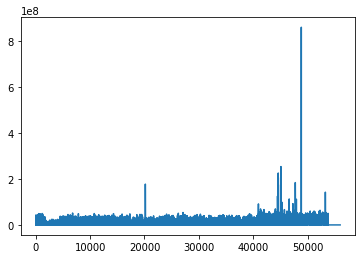

In [32]:
from sklearn.neighbors import NearestNeighbors

knn1 = NearestNeighbors()
knn1.fit(X1_train[train_normal])

# distances and indexes of k-neaighbors from model outputs
distances, indexes = knn1.kneighbors(X1_train[train_normal])
# plot mean of k-distances of each observation
pyplot.plot(distances.mean(axis =1))

#y1_pred_test = knn1.predict(X1_test)

#print(confusion_matrix(y1_test, y1_pred_knn))
#print('precision = ', precision_score(y1_test, y1_pred_knn))
#print('recall = ', recall_score(y1_test, y1_pred_knn))
#print('f1_score = ', f1_score(y1_test, y1_pred_knn))

## XGB Classifier(Optional)

XGB Classifier experiments for binary classifications.
This is not an unsupervised learning method. down below is just for the comparison purpose.

In [44]:
def y_xgb_format(y):
    '''
    Accepts a target value of 1 or -1(sklearn) and reformats to the appropriate class for xgb classifer models.
    inlier(normal case): 1 -> 0
    outlier(abnormal case): -1 -> 1
    '''
    if y == 1:
        return 0
    elif y == -1:
        return 1
    else:
        print('Unexpected input:', y)
        raise ValueError ('Unexpected input')

In [49]:
xgb_clsfr1 = XGBClassifier()
xgb_clsfr1.fit(X1_train, y1_train.apply(y_xgb_format))

y1_pred_xgb = xgb_clsfr1.predict(X1_test)

print(confusion_matrix(y1_test.apply(y_xgb_format), y1_pred_xgb))
print('precision = ', precision_score(y1_test.apply(y_xgb_format), y1_pred_xgb))
print('recall = ', recall_score(y1_test.apply(y_xgb_format), y1_pred_xgb))
print('f1_score = ', f1_score(y1_test.apply(y_xgb_format), y1_pred_xgb))

[[27489  9511]
 [  745 44587]]
precision =  0.824189433990166
recall =  0.9835656931086209
f1_score =  0.8968520567233229


In [50]:
xgb_clsfr2 = XGBClassifier()
xgb_clsfr2.fit(X2_train, y2_train.apply(y_xgb_format))

y2_pred_xgb = xgb_clsfr2.predict(X2_test)

print(confusion_matrix(y2_test.apply(y_xgb_format), y2_pred_xgb))
print('precision = ', precision_score(y2_test.apply(y_xgb_format), y2_pred_xgb))
print('recall = ', recall_score(y2_test.apply(y_xgb_format), y2_pred_xgb))
print('f1_score = ', f1_score(y2_test.apply(y_xgb_format), y2_pred_xgb))

[[27489  9511]
 [  745 44587]]
precision =  0.824189433990166
recall =  0.9835656931086209
f1_score =  0.8968520567233229


In [51]:
xgb_clsfr3 = XGBClassifier()
xgb_clsfr3.fit(X3_train, y3_train.apply(y_xgb_format))

y3_pred_xgb = xgb_clsfr3.predict(X3_test)

print(confusion_matrix(y3_test.apply(y_xgb_format), y3_pred_xgb))
print('precision = ', precision_score(y3_test.apply(y_xgb_format), y3_pred_xgb))
print('recall = ', recall_score(y3_test.apply(y_xgb_format), y3_pred_xgb))
print('f1_score = ', f1_score(y3_test.apply(y_xgb_format), y3_pred_xgb))

[[22145 14855]
 [  248 45084]]
precision =  0.7521647007791255
recall =  0.9945292508603194
f1_score =  0.8565321883519678


In [52]:
xgb_clsfr4 = XGBClassifier()
xgb_clsfr4.fit(X4_train, y4_train.apply(y_xgb_format))

y4_pred_xgb = xgb_clsfr4.predict(X4_test)

print(confusion_matrix(y4_test.apply(y_xgb_format), y4_pred_xgb))
print('precision = ', precision_score(y4_test.apply(y_xgb_format), y4_pred_xgb))
print('recall = ', recall_score(y4_test.apply(y_xgb_format), y4_pred_xgb))
print('f1_score = ', f1_score(y4_test.apply(y_xgb_format), y4_pred_xgb))

[[22145 14855]
 [  248 45084]]
precision =  0.7521647007791255
recall =  0.9945292508603194
f1_score =  0.8565321883519678


In [53]:
xgb_clsfr5 = XGBClassifier()
xgb_clsfr5.fit(X5_train, y5_train.apply(y_xgb_format))

y5_pred_xgb = xgb_clsfr5.predict(X5_test)

print(confusion_matrix(y5_test.apply(y_xgb_format), y5_pred_xgb))
print('precision = ', precision_score(y5_test.apply(y_xgb_format), y5_pred_xgb))
print('recall = ', recall_score(y5_test.apply(y_xgb_format), y5_pred_xgb))
print('f1_score = ', f1_score(y5_test.apply(y_xgb_format), y5_pred_xgb))

[[22415 14585]
 [  244 45088]]
precision =  0.7555846027516633
recall =  0.9946174887496692
f1_score =  0.8587781534212656


In [54]:
xgb_clsfr6 = XGBClassifier()
xgb_clsfr6.fit(X6_train, y6_train.apply(y_xgb_format))

y6_pred_xgb = xgb_clsfr6.predict(X6_test)

print(confusion_matrix(y6_test.apply(y_xgb_format), y6_pred_xgb))
print('precision = ', precision_score(y6_test.apply(y_xgb_format), y6_pred_xgb))
print('recall = ', recall_score(y6_test.apply(y_xgb_format), y6_pred_xgb))
print('f1_score = ', f1_score(y6_test.apply(y_xgb_format), y6_pred_xgb))

[[21933  1317]
 [  977 40192]]
precision =  0.9682719410248379
recall =  0.9762685515800724
f1_score =  0.9722538039139795
